In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

import requests
import json
from tqdm import tqdm
from emoji import demojize
from nltk.tokenize import TweetTokenizer
import os
from datetime import datetime

import numpy as np

import pandas as pd
from collections import Counter

# Define a list of filenames to load
filenames = ["../data/labeled_data/generic_test_0.json"]

# Load all JSON data and concatenate into one DataFrame
dfs = []
for filename in filenames:
    with open(filename) as f:
        data = json.load(f)
    df = pd.DataFrame(data["train"])
    dfs.append(df)
    df = pd.DataFrame(data["test"])
    dfs.append(df)
    df = pd.DataFrame(data["valid"])
    dfs.append(df)
df_all = pd.concat(dfs)

# Assuming your DataFrame is called df_all and has an "annotations" column
label_counts = Counter()

for labels in df_all['annotations']:
    label_counts.update(labels)

# Print the occurrences of each label
print(label_counts)

Counter({'Government/Public': 1539, 'Others': 1328, 'War/Terror': 1194, 'Justice/Crime': 709, 'Macroeconomics/Economic Regulation': 312, 'Conspiracy Theory': 299, 'Health': 260, 'Immigration/Integration': 237, 'Media/Journalism': 232, 'Election Campaign': 166, 'Labor/Employment': 125, 'Religion': 82, 'Education': 76, 'Environment': 72, 'Science/Technology': 65})


In [2]:
def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "[url]"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token
    
def normalizeTweet(tweet):
    tokens = TweetTokenizer().tokenize(tweet.replace("’", "'"))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("n 't", "n't")
            .replace("ca n't", "can't")
            .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("p . m .", "pm")
            .replace("p . m", "pm")
            .replace("a . m .", "am")
            .replace("a . m", "am")
    )
    return " ".join(normTweet.split())

def api(prompt):
    import requests

# For local streaming, the websockets are hosted without ssl - http://
HOST = 'http://127.0.0.1:5000'
URI = f'{HOST}/api/v1/generate'

# For reverse-proxied streaming, the remote will likely host with ssl - https://
# URI = 'https://your-uri-here.trycloudflare.com/api/v1/generate'

def get_response(request_params, prompt, context):
    request_params['prompt'] = prompt
    request_params['context'] = context

    response = requests.post(URI, json=request_params)

    if response.status_code == 200:
        result = response.json()['results'][0]['text']
        #print(prompt + result)
        return result
    else:
    	print(response)

def get_base_request_params(max_new_tokens = 200, stopping_strings = []):
    return {
        'prompt': None,
        'context': None,
        'max_new_tokens': 200,
        'do_sample': True,
        'temperature': 0.7,
        'top_p': 0.1,
        'typical_p': 1,
        'repetition_penalty': 1.2,
        'encoder_repetition_penalty': 1.0,
        'top_k': 40,
        'min_length': 0,
        'no_repeat_ngram_size': 0,
        'num_beams': 1,
        'penalty_alpha': 0,
        'length_penalty': 1,
        'early_stopping': False,
        'seed': -1,
        #'add_bos_token': True,
        #'truncation_length': 2048,
        #'ban_eos_token': False,
        #'skip_special_tokens': True,
        'stopping_strings': stopping_strings
    }

def get_openassistant_llama_30b_4bit_without_context_only_classification_v01(tweet_text, label):
    prompt = f"Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nTweet: {tweet_text}\nClass: "
    context = ''
    return prompt, context

def get_openassistant_llama_30b_4bit_without_context_only_classification_v02(tweet_text, label):
    prompt = f"Give the tweet a binary class based on if it's about {label} or not.\n\nTweet: {tweet_text}\nClass: "
    context = ''
    return prompt, context

def get_openassistant_llama_30b_4bit_without_context_only_classification_v03(tweet_text, label):
    prompt = f"Assign 1 if the tweet is about {label}. Assign 0 if it is not about {label}.\n\nTweet: {tweet_text}\nClass: "
    context = ''
    return prompt, context

def get_openassistant_llama_30b_4bit_few_shot_prompt_only_classification_1_pos_example(tweet_text, label, example_tweet):
    prompt = f"Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: 1\n\nTweet: {tweet_text}\nClass: "
    return prompt, ""

def get_openassistant_llama_30b_4bit_few_shot_prompt_only_classification_1_neg_example(tweet_text, label, example_tweet):
    prompt = f"Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: 0\n\nTweet: {tweet_text}\nClass: "
    return prompt, ""

def get_openassistant_llama_30b_4bit_few_shot_prompt_only_classification_1_random_example(tweet_text, label, example_tweet, example_tweet_label):
    prompt = f"Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: {example_tweet_label}\n\nTweet: {tweet_text}\nClass: "
    return prompt, ""

def get_openassistant_llama_30b_4bit_few_shot_prompt_only_classification_1_pos_1_neg_example(tweet_text, label, pos_example_tweet, neg_example_tweet):
    prompt = f"Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {pos_example_tweet}\nClass: 1\nExample Tweet: {neg_example_tweet}\nClass: 0\n\nTweet: {tweet_text}\nClass: "
    return prompt, ""

def get_openassistant_llama_30b_4bit_few_shot_prompt_only_classification_n_random_example(tweet_text, label, example_tweets):
    example_tweets_str = ""
    for example_tweet in example_tweets:
        example_tweets_str += f"\nExample Tweet: {normalizeTweet(example_tweet[0])}\nClass: {example_tweet[1]}"
    prompt = f"Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.{example_tweets_str}\n\nTweet: {tweet_text}\nClass: "
    return prompt, ""

def get_openassistant_llama_30b_4bit_without_context_elaboration_first(tweet_text, label):
    prompt = f"Elaborate on whether you think the Tweet is about {label} or something else.\nTweet: {tweet_text}\nElaboration: "
    context = ''
    return prompt, context

def get_vicuna_prompt_with_rules_only_classification(tweet_text, label, rules):
    prompt = f"### Human: Based on rules, classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\n\nRules: {rules}\nTweet: {tweet_text}\n### Assistant:\nClass:"
    context = ''
    return prompt, context

def get_vicuna_prompt_with_rules_elaboration_first(tweet_text, label, rules):
    prompt = f"### Human: Based on rules, elaborate whether you think the Tweet is about {label}.\nRules: {rules}\nTweet: {tweet_text}\n### Assistant:\nElaboration: "
    context = ''
    return prompt, context

def get_vicuna_prompt_without_context_elaboration_first(tweet_text, label):
    prompt = f"### Human: Elaborate on whether you think the Tweet is about {label} or something else.\nTweet: {tweet_text}\n### Assistant:\nElaboration: "
    followup = f":\n Assign class 1 for {label} or 0 for not. \n###Assistant:\nClass: "
    return prompt, followup

def get_vicuna_prompt_without_context_elaboration_first_v02(tweet_text, label):
    prompt = f"### Human: Elaborate on whether you think the Tweet is about {label} or something else.\nTweet: {tweet_text}\n### Assistant:\nElaboration: "
    followup = f"### Human: Based on the elaboration, classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nTweet: {tweet_text}\nElaboration: [ELABORATION]\n### Assistant:\nClass: "
    return prompt, followup

def get_vicuna_prompt_without_context_elaboration_first_v03(tweet_text, label):
    prompt = f"### Human: Elaborate on whether you think the Tweet is about {label} or something else.\nTweet: {tweet_text}\n### Assistant:\nElaboration: "
    followup = f"### Human: Based on the elaboration, assign 1 if it's about {label} or 0 if not.\nElaboration: [ELABORATION]\n### Assistant:\nClass: "
    return prompt, followup

def get_vicuna_prompt_without_context_only_classification(tweet_text, label):
    prompt = f"### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\n\nTweet: {tweet_text}\n### Assistant:\nClass: "
    context = ''
    return prompt, context

def get_vicuna_prompt_without_context_only_classification_v02(tweet_text, label):
    prompt = f"### Human: Give the tweet a binary class based on if it's about {label} or not.\n\nTweet: {tweet_text}\n### Assistant:\nClass: "
    context = ''
    return prompt, context

def get_vicuna_prompt_without_context_only_classification_v03(tweet_text, label):
    prompt = f"### Human: Assign 1 if the tweet is about {label}. Assign 0 if it is not about {label}.\n\nTweet: {tweet_text}\n### Assistant:\nClass: "
    context = ''
    return prompt, context
    
def get_vicuna_prompt_without_context_only_classification_v04(tweet_text, label):
    prompt = f"### Human: Is the Text about {label}? Answer with True or False.\n\nTweet: {tweet_text}\n### Assistant:\nResponse: "
    context = ''
    return prompt, context

def get_vicuna_few_shot_prompt_only_classification_1_pos_example(tweet_text, label, example_tweet):
    prompt = f"### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: 1\n\nTweet: {tweet_text}\nClass: "
    return prompt, ""

def get_vicuna_few_shot_prompt_only_classification_1_neg_example(tweet_text, label, example_tweet):
    prompt = f"### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: 0\n\nTweet: {tweet_text}\nClass: "
    return prompt, ""

def get_vicuna_few_shot_prompt_only_classification_1_random_example(tweet_text, label, example_tweet, example_tweet_label):
    prompt = f"### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: {example_tweet_label}\n\nTweet: {tweet_text}\nClass: "
    return prompt, ""

def get_vicuna_few_shot_prompt_only_classification_n_random_example(tweet_text, label, example_tweets):
    example_tweets_str = ""
    for example_tweet in example_tweets:
        example_tweets_str += f"\nExample Tweet: {normalizeTweet(example_tweet[0])}\nClass: {example_tweet[1]}"
    prompt = f"### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.{example_tweets_str}\n\nTweet: {tweet_text}\nClass: "
    return prompt, ""

def get_vicuna_few_shot_prompt_only_classification_n_random_example_v02(tweet_text, label, example_tweets):
    example_tweets_str = ""
    for example_tweet in example_tweets:
        example_tweets_str += f"\n\nTweet: {normalizeTweet(example_tweet[0])}\n### Assistant:\nClass: {example_tweet[1]}"
    prompt = f"### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.{example_tweets_str}\n\nTweet: {tweet_text}\n### Assistant:\nClass: "
    return prompt, ""

def get_vicuna_few_shot_prompt_only_classification_1_pos_1_neg_example(tweet_text, label, pos_example_tweet, neg_example_tweet):
    prompt = f"### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {pos_example_tweet}\nClass: 1\nExample Tweet: {neg_example_tweet}\nClass: 0\n\nTweet: {tweet_text}\nClass: "
    return prompt, ""

def get_gpt4xalpaca_4bit_prompt_basic_elaboration_first(tweet_text, label):
    prompt = f'### Instruction:\nElaborate on whether you think the Tweet is about {label} or something else.\n\nTweet: {tweet_text}\n\n### Response:'
    context = ''
    return prompt, context

def get_gpt4xalpaca_4bit_prompt_without_context_only_classification(tweet_text, label, request_params):
    instruction = f"Classify the Tweet based on if it's about {label}. Use 1 or 0 as class."
    prompt = f'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input:\n{tweet_text}\n\n### Response:\n'
    context = ''
    request_params["max_new_tokens"] = 10
    return prompt, context, request_params

def get_gpt4xalpaca_4bit_prompt_without_context_only_classification_v02(tweet_text, label, request_params):
    instruction = f"Give the tweet a binary class based on if it's about {label} or not."
    prompt = f'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input:\n{tweet_text}\n\n### Response:\n'
    context = ''
    request_params["max_new_tokens"] = 10
    return prompt, context, request_params

def get_gpt4xalpaca_4bit_prompt_without_context_only_classification_v03(tweet_text, label, request_params):
    instruction = f"Assign 1 if the tweet is about {label}. Assign 0 if it is not about {label}."
    prompt = f'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input:\n{tweet_text}\n\n### Response:\n'
    context = ''
    request_params["max_new_tokens"] = 10
    return prompt, context, request_params

def get_gpt4xalpaca_4bit_prompt_without_context_elaboration_first_v04(tweet_text, label, request_params):
    instruction = f"Classify the Tweet based on if it's about {label}. Give an explanation using \"Explanation:\" then classify using \"Class:\" as 1 or 0."
    prompt = f'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input:\n{tweet_text}\n\n### Response:\n'
    context = ''
    request_params["max_new_tokens"] = 400
    return prompt, context, request_params

def get_vicuna_prompt_without_context_elaboration_first_v04(tweet_text, label, request_params):
    prompt = f"### Human:\nClassify the Tweet based on if it's about {label}. Give an explanation using \"Explanation:\" then classify using \"Class:\" as 1 or 0.\n\nTweet:\n{tweet_text}\n\n### Assistant:\n"
    context = ''
    request_params["max_new_tokens"] = 400
    return prompt, context, request_params

def get_openassistant_llama_30b_4bit_prompt_without_context_elaboration_first_v04(tweet_text, label, request_params):
    prompt = f"### Instruction:\nClassify the Tweet based on if it's about {label}. Give an explanation using \"Explanation:\" then classify using \"Class:\" as 1 or 0.\n\nTweet:\n{tweet_text}\n\n### Response:\n"
    context = ''
    request_params["max_new_tokens"] = 400
    return prompt, context, request_params

def get_positive_example(df, label, exclude_tweet):
    pos_example_df = df[(df['annotations'].apply(lambda x: label in x)) & (df['text'] != exclude_tweet)]
    pos_example_tweet = pos_example_df.sample(n=1, random_state=42)['text'].values[0]
    return pos_example_tweet

def get_negative_example(df, label, exclude_tweet):
    neg_example_df = df[(df['annotations'].apply(lambda x: label not in x)) & (df['text'] != exclude_tweet)]
    neg_example_tweet = neg_example_df.sample(n=1, random_state=42)['text'].values[0]
    return neg_example_tweet

def get_random_examples(df, label, exclude_tweet, n):
    # Exclude the specific tweet
    df = df[df['text'] != exclude_tweet]
    
    # Sample n random examples
    sampled_df = df.sample(n=n, random_state=42)
    
    # Return a list of tuples, each containing the tweet text and its annotations
    return list(zip(sampled_df['text'].values, sampled_df['annotations'].apply(lambda x: int(label in x)).values))

In [3]:
get_random_examples(df_all, "War/Terror", "Hong Kong customs arrested 40 kilogrammes of Joburg rhino horns\nhttps://t.co/fr7WWNPkRl", 3)

[('RT @coleftaylor1: "Corporations have neither a soul to save nor a body to incarcerate" Baron Thoreau',
  0),
 ('Trump Ditches the Press to Play Golf! https://t.co/YkyVal3usR https://t.co/IjeqeVSL71',
  0),
 ('The best thing you have to offer Venezuela @realDonaldTrump is military aggression! The kind of imperial help they brought to Iraq, Libya, Syria. The people of Venezuela will never allow any empire to threaten our national integrity again! Free x always in peace! @DrodriguezVen',
  1)]

In [4]:
import pandas as pd

# Your original DataFrame: df_all
# all_labels: list of labels

balanced_dfs = []

rules = ["Oxford dictionary's definition of war: “situation in which two or more countries or groups of people fight against each other over a period of time”. Oxford dictionary's definition of terror (terrorism): “violent action or the threat of violent action that is intended to cause fear, usually for political purposes”. Remark: This category includes also causes and consequences of war/terror (e.g. “the current situation in Ukraine may cause a supply crisis for wheat products”).",
"Oxford dictionary's definition of conspiracy: “a secret plan by a group of people to do something harmful or illegal”. Remark: Assignment of this category may depend on viewpoint and political stance of rater, which can be mitigated by focusing on the definition above. If the content of a tweet describes a conspiratorial activity/process, it will be labeled “conspiracy theory”.",
"Oxford dictionary's definition of education: “a process of teaching, training and learning, especially in schools, colleges or universities, to improve knowledge and develop skills”. Remark: Does not include education/training of soldiers (🡪war/terror).",
"Oxford dictionary's definition of election: “the process of choosing a person or a group of people for a position, especially a political position, by voting”. Remark: This category includes all activities aimed at rallying the population for participation in a public election, description of election outcomes, and conduct of the election itself.",
"Oxford dictionary's definition of environment: “the natural world in which people, animals and plants live”. Remark: This category is typically used for tweet content revolving around activities and processes affecting the environment in some way.",
"Oxford dictionary's definition of government: “the group of people who are responsible for controlling a country or a state”. Oxford dictionary's definition of public: “ordinary people who are not members of a particular group or organization” Remark: This category includes also statements/content about the public perception of activities/processes of government (i.e. voiced criticism or praise for a government).",
"Oxford dictionary's definition of health: “the condition of a person's body or mind”. Remark: This category includes also statements related to public health. In such a case both Health and Government/Public must be selected.",
"Oxford dictionary's definition of immigration: “the process of coming to live permanently in a different country from the one you were born in”. Oxford dictionary's definition of integration: “the act or process of mixing people who have previously been separated, usually because of colour, race, religion, etc.”",
"Oxford dictionary's definition of justice: “the legal system used to punish people who have committed crimes”. Oxford dictionary's definition of crime: “activities that involve breaking the law”. Remark: This category does not include statements/content on war crimes (🡪 war/terror).",
"Oxford dictionary's definition of labor: “work, especially physical work”. Oxford dictionary's definition of employment: “work, especially when it is done to earn money; the state of being employed”.",
"Oxford dictionary's definition of macroeconomics: “the study of large economic systems, such as those of whole countries or areas of the world”. Oxford dictionary's definition of regulation: ”an official rule made by a government or some other authority”. Remark: In case of statements/content on economic regulations, this category may likely co-occur with Government/Public category.", 
"Oxford dictionary's definition of media: “the main ways that large numbers of people receive information and entertainment, that is television, radio, newspapers and the internet”. Oxford dictionary's definition of journalism: “the work of collecting and writing news stories for newspapers, magazines, radio, television or online news sites; the news stories that are written”. Remark: This category will be used for statements/content which explicitly references other media outlets or journalists (e.g. “BBC has reported that …”, “Bellingcat has discovered a secret operation of X”). Content which appears “news-worthy” does not generally fall into this category (🡪 newsworthiness is very subjective and context-dependent).",
"Oxford dictionary's definition of religion: “the belief in the existence of a god or gods, and the activities that are connected with the worship of them, or in the teachings of a spiritual leader”.",
"Oxford dictionary's definition of science: “knowledge about the structure and behavior of the natural and physical world, based on facts that you can prove, for example by experiments”. Oxford dictionary's definition of technology: “scientific knowledge used in practical ways in industry, for example in designing new machines”."]

all_labels = ["War/Terror", "Conspiracy Theory", "Education", "Election Campaign", "Environment", 
              "Government/Public", "Health", "Immigration/Integration", 
              "Justice/Crime", "Labor/Employment", 
              "Macroeconomics/Economic Regulation", "Media/Journalism", "Religion", "Science/Technology"]

for label in all_labels:
    # Initialize an empty DataFrame for the balanced dataset
    balanced_df = pd.DataFrame()
    # Get the rows with the current label
    label_rows = df_all[df_all['annotations'].apply(lambda x: label in x)]
    
    # Get the rows without the current label
    non_label_rows = df_all[df_all['annotations'].apply(lambda x: label not in x)]
    
    # Sample 65 rows with the current label
    sample_label_rows = label_rows.sample(n=65, random_state=42)
    
    # Sample 65 rows without the current label
    sample_non_label_rows = non_label_rows.sample(n=65, random_state=42)
    
    # Combine the samples
    combined_sample = pd.concat([sample_label_rows, sample_non_label_rows], ignore_index=True)
    
    # Add the samples to the balanced DataFrame
    balanced_df = pd.concat([balanced_df, combined_sample], ignore_index=True)

    balanced_dfs.append(balanced_df)

In [6]:
import random

## Change output_folder, models_to_test_names, and model_funcs to match the models you want to test
output_folder = "../data/openassistant_llama_30b_4bit/"
models_to_test_names = ["generic_prompt_without_context_elaboration_first_v04"]
model_funcs = [get_openassistant_llama_30b_4bit_prompt_without_context_elaboration_first_v04]

for model_name, model_func in zip(models_to_test_names, model_funcs):
    print("Starting with model: " + model_name)
    print("----------------------------------")
    df_all_tmp = df_all.copy()

    df_all_tmp['normalized_tweet'] = None
    normalized_tweets_db = {}
    output_folder_tmp = f"{output_folder}{model_name}/"

    if not os.path.exists(output_folder_tmp):
        os.makedirs(output_folder_tmp)

    for idx, label in enumerate(all_labels):

        sample_df = balanced_dfs[idx]

        print("Starting requesting for label: " + label + "\n")

        new_column_name = f'{label}_pred'
        df_all_tmp[new_column_name] = None
        request_params = get_base_request_params()

        i = 0
        for index, row in tqdm(sample_df.iterrows(), total=sample_df.shape[0]):

            tweet_text = normalizeTweet(row['text'])
            df_all_tmp.loc[lambda df: df['id'] == row["id"], 'normalized_tweet'] = tweet_text

            pos_example_tweet = get_positive_example(sample_df, label, row["text"])
            neg_example_tweet = get_negative_example(sample_df, label, row["text"])

            pos_example_tweet = normalizeTweet(pos_example_tweet)
            neg_example_tweet = normalizeTweet(neg_example_tweet)

            # select the function based on model_func and generate the prompt
            if '1_pos_example' in model_func.__name__:
                prompt, followup = model_func(tweet_text, label, pos_example_tweet)
            elif '1_neg_example' in model_func.__name__:
                prompt, followup = model_func(tweet_text, label, neg_example_tweet)
            elif '1_random_example' in model_func.__name__:
                example_tweet = random.choice([pos_example_tweet, neg_example_tweet])
                example_tweet_label = 1 if example_tweet == pos_example_tweet else 0
                prompt, followup = model_func(tweet_text, label, example_tweet, example_tweet_label)
            elif '_random_example' in model_func.__name__:
                examples = get_random_examples(sample_df, label, row["text"], 3) #set number of examples here
                prompt, followup = model_func(tweet_text, label, examples)
            elif '1_pos_1_neg_example' in model_func.__name__:
                prompt, followup = model_func(tweet_text, label, pos_example_tweet, neg_example_tweet)
            else:
                prompt, followup, request_params = model_func(tweet_text, label, request_params)

            request_params["stopping_strings"] = ["### Human:", "Human:", "###"]
            response = get_response(request_params, prompt, "")

            # Save the response in the 'api_results' column
            df_all_tmp.loc[lambda df: df['id'] == row["id"], new_column_name] = response
            
            i+=1
            # Save the DataFrame to a CSV file every 100 steps
            if (i + 1) % 100 == 0:
                output_path = os.path.join(output_folder_tmp, 'generic_test_0.csv')
                df_all_tmp.to_csv(output_path, index=False)
                print(f"Saved progress at index {index}")
                print("Sample Tweet: ", tweet_text)
                print("Sample Annotation: ", response)

        # Save the final DataFrame to a CSV file
        output_path = os.path.join(output_folder_tmp, 'generic_test_0.csv')
        df_all_tmp.to_csv(output_path, index=False)

    # Save the request_params as a JSON file in the output folder
    with open(os.path.join(output_folder_tmp, 'request_params.json'), 'w') as f:
        json.dump(request_params, f, indent=4)


Starting with model: generic_prompt_without_context_elaboration_first_v04
----------------------------------
Starting requesting for label: War/Terror



 76%|███████▌  | 99/130 [11:58<03:31,  6.82s/it]

Saved progress at index 98
Sample Tweet:  Cleric accused of masterminding 2008 Mumbai attacks under house arrest [url] [url]
Sample Annotation:  Explanation: This tweet is about a cleric who has been accused of being involved in terrorism, specifically with regards to the 2008 Mumbai attacks. The fact that he is currently under house arrest suggests that there may be evidence linking him to these crimes.

Class: 1


100%|██████████| 130/130 [15:11<00:00,  7.01s/it]


Starting requesting for label: Conspiracy Theory



 76%|███████▌  | 99/130 [11:32<02:50,  5.51s/it]

Saved progress at index 98
Sample Tweet:  #Almost all militants of illegal #armed #groups refuse to move to the #front line . #Syria #Idlib
Sample Annotation:  Explanation: This tweet is not related to conspiracy theory, but rather discussing a current event in Syria.
Class: 0


100%|██████████| 130/130 [14:34<00:00,  6.73s/it]


Starting requesting for label: Education



 76%|███████▌  | 99/130 [08:57<02:21,  4.58s/it]

Saved progress at index 98
Sample Tweet:  Desperate Clinton Campaign Doubts “ Legitimacy ” of Trump's Win One Week from Inauguration [url] [url]
Sample Annotation:  Explanation: This tweet is not related to education, but rather discussing politics and the legitimacy of a political win.
Class: 0


100%|██████████| 130/130 [11:26<00:00,  5.28s/it]


Starting requesting for label: Election Campaign



 76%|███████▌  | 99/130 [10:01<02:44,  5.31s/it]

Saved progress at index 98
Sample Tweet:  He's At It Again ! This Guy's Hilarious Photoshop ' Fixes ' Will Make Your Day [url]
Sample Annotation:  Explanation: The tweet is not related to any election campaign, so I would classify this as Class: 0


100%|██████████| 130/130 [13:09<00:00,  6.07s/it]


Starting requesting for label: Environment



 76%|███████▌  | 99/130 [09:07<02:17,  4.45s/it]

Saved progress at index 98
Sample Tweet:  PA Sec of State Releases 20 Electors Names , Addresses and Phone Numbers ! [url] [url]
Sample Annotation:  Explanation: This tweet is not related to environment, but rather a political issue in Pennsylvania regarding electoral college members.
Class: 0


100%|██████████| 130/130 [11:33<00:00,  5.33s/it]


Starting requesting for label: Government/Public



 76%|███████▌  | 99/130 [09:43<02:44,  5.31s/it]

Saved progress at index 98
Sample Tweet:  #CrazySocks4Docs : raising awareness about depression amongst doctors - [url] Thanduxolo Buti The #CrazySocks4Docs campaign hopes to end the stigma and help curb the high number of depression and suicide case amongst doctors and medicine students . The campaig ... [url]
Sample Annotation:  Explanation: This tweet is not related to government or public affairs, but rather a social issue that affecting people in general.
Class: 0


100%|██████████| 130/130 [12:34<00:00,  5.80s/it]


Starting requesting for label: Health



 76%|███████▌  | 99/130 [09:25<03:19,  6.42s/it]

Saved progress at index 98
Sample Tweet:  One suspect was arrested in Soweto . During the search , a plastic bag containing 3500 mandrax tablets , 7 plastic bags containing dagga , a box with 25 9mm live rounds and 1 black 9mm Z88 were discovered . [url]
Sample Annotation:  Explanation: This tweet is not related to health, but rather reports a drug-related crime that occurred in Soweto. The discovery of drugs such as mandrax and dagga suggests that they may have been intended for illegal distribution or consumption. However, this information does not provide any insights into public health issues.

Class: 0


100%|██████████| 130/130 [11:59<00:00,  5.53s/it]


Starting requesting for label: Immigration/Integration



 76%|███████▌  | 99/130 [09:50<02:46,  5.37s/it]

Saved progress at index 98
Sample Tweet:  Susan Rice and the Russians . Will Obama's new national security advisor play nice and get along with Moscow ? [url]
Sample Annotation:  Explanation: This tweet is not related to immigration or integration. It discusses a political topic, specifically Susan Rice and her relationship with Russia.

Class: 0


100%|██████████| 130/130 [12:52<00:00,  5.94s/it]


Starting requesting for label: Justice/Crime



 76%|███████▌  | 99/130 [09:51<03:13,  6.24s/it]

Saved progress at index 98
Sample Tweet:  jacques christian Retweet RT RT_America to #MAGA ! [url] 490 [url] [url]
Sample Annotation:  Explanation: This tweet is not related to justice or crime, but rather a retweet of a news article from Real Clear Politics titled "The FBI and CIA Are in Crisis—and It’s All Because of Trump". The tweet does not mention anything about justice or crime.

Class: 0


100%|██████████| 130/130 [12:56<00:00,  5.97s/it]


Starting requesting for label: Labor/Employment



 76%|███████▌  | 99/130 [09:34<02:32,  4.91s/it]

Saved progress at index 98
Sample Tweet:  The #SyrianArabArmy and allied forces : struck at the headquarters of #Djebhat anNusra " in the west of #Idlib . [url]
Sample Annotation:  Explanation: This tweet is not related to labor or employment, so I would classify this as a 0.


100%|██████████| 130/130 [12:28<00:00,  5.76s/it]


Starting requesting for label: Macroeconomics/Economic Regulation



 76%|███████▌  | 99/130 [10:45<03:05,  5.97s/it]

Saved progress at index 98
Sample Tweet:  " During my husbands presidency .. " Now I can use her husbands terrible policies as much as I want against her . #Debates @USER
Sample Annotation:  Explanation: This tweet is not related to macroeconomics or economic regulations, but rather a political commentary.
Class: 0


100%|██████████| 130/130 [13:41<00:00,  6.32s/it]


Starting requesting for label: Media/Journalism



 76%|███████▌  | 99/130 [10:19<02:52,  5.55s/it]

Saved progress at index 98
Sample Tweet:  RT PoliticsPeach : Alyssa_Milano jgreenSTPA Was this Obama's America & police state that you ppl are trying your best to erase as th … …
Sample Annotation:  Explanation: This tweet is not related to media or journalism, but rather a political statement.
Class: 0


100%|██████████| 130/130 [13:27<00:00,  6.21s/it]


Starting requesting for label: Religion



 76%|███████▌  | 99/130 [09:49<02:33,  4.95s/it]

Saved progress at index 98
Sample Tweet:  The police have confirmed the deaths of 3 fishermen after a small vessel capsised on Lake Mweru . The group went fishing but their boat overturned as a result of strong winds . The bodies of the drowned had not been recovered yet . The officers have launched the investigation .
Sample Annotation:  Explanation: This tweet is not related to religion, therefore I would classify this as 0.


100%|██████████| 130/130 [12:23<00:00,  5.72s/it]


Starting requesting for label: Science/Technology



 76%|███████▌  | 99/130 [09:20<02:39,  5.16s/it]

Saved progress at index 98
Sample Tweet:  @USER smashing it up with Amanya Gange @USER #MondayMotivation #LAFTAZ 25thAUGUST 👇🏻 👇🏻 #MegaSHIRUMATICXperience
Sample Annotation:  Explanation: This tweet is not related to science and technology, but rather a social event.
Class: 0


100%|██████████| 130/130 [11:59<00:00,  5.53s/it]


In [9]:
import random

## Change output_folder, models_to_test_names, and model_funcs to match the models you want to test
output_folder = "../data/openassistant_llama_30b_4bit/"
models_to_test_names = ["generic_prompt_few_shot_prompt_only_classification_10_random_example"]
model_funcs = [get_openassistant_llama_30b_4bit_few_shot_prompt_only_classification_n_random_example]

for model_name, model_func in zip(models_to_test_names, model_funcs):
    print("Starting with model: " + model_name)
    print("----------------------------------")
    df_all_tmp = df_all.copy()

    df_all_tmp['normalized_tweet'] = None
    normalized_tweets_db = {}
    output_folder = f"{output_folder}{model_name}/"

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for idx, label in enumerate(all_labels):

        sample_df = balanced_dfs[idx]

        print("Starting requesting for label: " + label + "\n")

        new_column_name = f'{label}_pred'
        df_all_tmp[new_column_name] = None
        request_params = get_base_request_params()

        i = 0
        for index, row in tqdm(sample_df.iterrows(), total=sample_df.shape[0]):

            tweet_text = normalizeTweet(row['text'])
            df_all_tmp.loc[lambda df: df['id'] == row["id"], 'normalized_tweet'] = tweet_text

            pos_example_tweet = get_positive_example(sample_df, label, row["text"])
            neg_example_tweet = get_negative_example(sample_df, label, row["text"])

            pos_example_tweet = normalizeTweet(pos_example_tweet)
            neg_example_tweet = normalizeTweet(neg_example_tweet)

            # select the function based on model_func and generate the prompt
            if '1_pos_example' in model_func.__name__:
                prompt, followup = model_func(tweet_text, label, pos_example_tweet)
            elif '1_neg_example' in model_func.__name__:
                prompt, followup = model_func(tweet_text, label, neg_example_tweet)
            elif '1_random_example' in model_func.__name__:
                example_tweet = random.choice([pos_example_tweet, neg_example_tweet])
                example_tweet_label = 1 if example_tweet == pos_example_tweet else 0
                prompt, followup = model_func(tweet_text, label, example_tweet, example_tweet_label)
            elif '_random_example' in model_func.__name__:
                examples = get_random_examples(sample_df, label, row["text"], 10)
                prompt, followup = model_func(tweet_text, label, examples)
            elif '1_pos_1_neg_example' in model_func.__name__:
                prompt, followup = model_func(tweet_text, label, pos_example_tweet, neg_example_tweet)

            request_params["stopping_strings"] = ["### Human:", "Human:", "###"]
            request_params["max_new_tokens"] = 5
            response = get_response(request_params, prompt, "")

            # Save the response in the 'api_results' column
            df_all_tmp.loc[lambda df: df['id'] == row["id"], new_column_name] = response
            
            i+=1
            # Save the DataFrame to a CSV file every 100 steps
            if (i + 1) % 100 == 0:
                output_path = os.path.join(output_folder, 'generic_test_0.csv')
                df_all_tmp.to_csv(output_path, index=False)
                print(f"Saved progress at index {index}")
                print("Sample Tweet: ", tweet_text)
                print("Sample Annotation: ", response)

        # Save the final DataFrame to a CSV file
        output_path = os.path.join(output_folder, 'generic_test_0.csv')
        df_all_tmp.to_csv(output_path, index=False)

    # Save the request_params as a JSON file in the output folder
    with open(os.path.join(output_folder, 'request_params.json'), 'w') as f:
        json.dump(request_params, f, indent=4)

Starting with model: generic_prompt_few_shot_prompt_only_classification_10_random_example
----------------------------------
Starting requesting for label: War/Terror



 76%|███████▌  | 99/130 [04:02<01:11,  2.29s/it]

Saved progress at index 98
Sample Tweet:  Cleric accused of masterminding 2008 Mumbai attacks under house arrest [url] [url]
Sample Annotation:  0


100%|██████████| 130/130 [05:13<00:00,  2.41s/it]


Starting requesting for label: Conspiracy Theory



 76%|███████▌  | 99/130 [03:52<01:10,  2.27s/it]

Saved progress at index 98
Sample Tweet:  #Almost all militants of illegal #armed #groups refuse to move to the #front line . #Syria #Idlib
Sample Annotation:  1


100%|██████████| 130/130 [05:02<00:00,  2.32s/it]


Starting requesting for label: Education



 76%|███████▌  | 99/130 [03:57<01:14,  2.39s/it]

Saved progress at index 98
Sample Tweet:  Desperate Clinton Campaign Doubts “ Legitimacy ” of Trump's Win One Week from Inauguration [url] [url]
Sample Annotation:  0


100%|██████████| 130/130 [05:14<00:00,  2.42s/it]


Starting requesting for label: Election Campaign



 76%|███████▌  | 99/130 [04:01<01:12,  2.35s/it]

Saved progress at index 98
Sample Tweet:  He's At It Again ! This Guy's Hilarious Photoshop ' Fixes ' Will Make Your Day [url]
Sample Annotation:  0


100%|██████████| 130/130 [05:14<00:00,  2.42s/it]


Starting requesting for label: Environment



 76%|███████▌  | 99/130 [04:12<01:14,  2.40s/it]

Saved progress at index 98
Sample Tweet:  PA Sec of State Releases 20 Electors Names , Addresses and Phone Numbers ! [url] [url]
Sample Annotation:  0


100%|██████████| 130/130 [05:26<00:00,  2.51s/it]


Starting requesting for label: Government/Public



 76%|███████▌  | 99/130 [03:41<01:09,  2.25s/it]

Saved progress at index 98
Sample Tweet:  #CrazySocks4Docs : raising awareness about depression amongst doctors - [url] Thanduxolo Buti The #CrazySocks4Docs campaign hopes to end the stigma and help curb the high number of depression and suicide case amongst doctors and medicine students . The campaig ... [url]
Sample Annotation:  1


100%|██████████| 130/130 [04:52<00:00,  2.25s/it]


Starting requesting for label: Health



 76%|███████▌  | 99/130 [03:45<01:09,  2.24s/it]

Saved progress at index 98
Sample Tweet:  One suspect was arrested in Soweto . During the search , a plastic bag containing 3500 mandrax tablets , 7 plastic bags containing dagga , a box with 25 9mm live rounds and 1 black 9mm Z88 were discovered . [url]
Sample Annotation:  1


100%|██████████| 130/130 [04:55<00:00,  2.28s/it]


Starting requesting for label: Immigration/Integration



 76%|███████▌  | 99/130 [03:42<01:09,  2.23s/it]

Saved progress at index 98
Sample Tweet:  Susan Rice and the Russians . Will Obama's new national security advisor play nice and get along with Moscow ? [url]
Sample Annotation:  0


100%|██████████| 130/130 [04:52<00:00,  2.25s/it]


Starting requesting for label: Justice/Crime



 76%|███████▌  | 99/130 [03:44<01:09,  2.25s/it]

Saved progress at index 98
Sample Tweet:  jacques christian Retweet RT RT_America to #MAGA ! [url] 490 [url] [url]
Sample Annotation:  0


100%|██████████| 130/130 [04:52<00:00,  2.25s/it]


Starting requesting for label: Labor/Employment



 76%|███████▌  | 99/130 [03:57<01:15,  2.44s/it]

Saved progress at index 98
Sample Tweet:  The #SyrianArabArmy and allied forces : struck at the headquarters of #Djebhat anNusra " in the west of #Idlib . [url]
Sample Annotation:  0


100%|██████████| 130/130 [05:14<00:00,  2.42s/it]


Starting requesting for label: Macroeconomics/Economic Regulation



 76%|███████▌  | 99/130 [03:47<01:12,  2.33s/it]

Saved progress at index 98
Sample Tweet:  " During my husbands presidency .. " Now I can use her husbands terrible policies as much as I want against her . #Debates @USER
Sample Annotation:  0


100%|██████████| 130/130 [04:58<00:00,  2.29s/it]


Starting requesting for label: Media/Journalism



 76%|███████▌  | 99/130 [04:07<01:17,  2.50s/it]

Saved progress at index 98
Sample Tweet:  RT PoliticsPeach : Alyssa_Milano jgreenSTPA Was this Obama's America & police state that you ppl are trying your best to erase as th … …
Sample Annotation:  1


100%|██████████| 130/130 [05:20<00:00,  2.47s/it]


Starting requesting for label: Religion



 76%|███████▌  | 99/130 [03:51<01:12,  2.35s/it]

Saved progress at index 98
Sample Tweet:  The police have confirmed the deaths of 3 fishermen after a small vessel capsised on Lake Mweru . The group went fishing but their boat overturned as a result of strong winds . The bodies of the drowned had not been recovered yet . The officers have launched the investigation .
Sample Annotation:  0


100%|██████████| 130/130 [05:04<00:00,  2.34s/it]


Starting requesting for label: Science/Technology



 76%|███████▌  | 99/130 [03:50<01:12,  2.35s/it]

Saved progress at index 98
Sample Tweet:  @USER smashing it up with Amanya Gange @USER #MondayMotivation #LAFTAZ 25thAUGUST 👇🏻 👇🏻 #MegaSHIRUMATICXperience
Sample Annotation:  0


100%|██████████| 130/130 [04:57<00:00,  2.29s/it]


In [7]:
from sklearn.metrics import f1_score, accuracy_score

# Confusion matrix values
tn = 3952
tp = 349
fp = 103
fn = 96

# True and predicted values
y_true = [0]*tn + [1]*tp + [0]*fp + [1]*fn
y_pred = [0]*tn + [1]*tp + [1]*fp + [0]*fn

# F1 scores for each label
f1_label_0 = f1_score(y_true, y_pred, pos_label=0)
f1_label_1 = f1_score(y_true, y_pred, pos_label=1)

# Average F1 score
f1_avg = (f1_label_0 + f1_label_1) / 2

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

print(f"F1 Score for label 0: {f1_label_0}")
print(f"F1 Score for label 1: {f1_label_1}")
print(f"Average F1 Score: {f1_avg}")
print(f"Accuracy: {accuracy}")

F1 Score for label 0: 0.9754411946192769
F1 Score for label 1: 0.7781493868450392
Average F1 Score: 0.8767952907321581
Accuracy: 0.9557777777777777


In [18]:
test_df = pd.read_csv("../data/gpt4xalpaca_4bit/generic_prompt_without_context_only_classification/generic_test_0.csv")
test_df = test_df[test_df["War/Terror_pred"].notna()]
print(test_df["normalized_tweet"].to_list())
test_df[["normalized_tweet", "annotations", "War/Terror_pred"]].head(10)

['Hong Kong customs arrested 40 kilogrammes of Joburg rhino horns [url]', 'Zambia is going to receive US $ 9m from the International Finance Corporation ( IFC ) for construction of Zambian hotel and conference centre on the suburbs of Lusaka . [url]', "A repatriation flight from Bangui M'Poko International Airport , #CentralAfricanRepublic , for the U . S . citizens is scheduled for April 19 . The approximate cost of this flight is $ 1,774 . It is unlikely that there will be another repatriation flight organized by @USER . [url]", 'Milky Way being pushed through space by cosmic dead zone , say scientists [url] [url]', 'This Friday , September 25 , the project " Voluntary surrender of arms and ammunition " was launched during the official ceremony attended by President of the #CentralAfricanRepublic Faustin Archange Touadéra and other high officials . [url]', 'RT @USER + + pK5Mrn2cOXrzHm71gg7YwrpNU =: UPDF soldiers in Somalia keeping law & order #securityug [url]', "It's reported that a

,normalized_tweet,annotations,War/Terror_pred
17,Hong Kong customs arrested 40 kilogrammes of J...,"['Environment', 'Justice/Crime']",Classification: 1
102,Zambia is going to receive US $ 9m from the In...,['Others'],Classification: 0
134,A repatriation flight from Bangui M'Poko Inter...,['Immigration/Integration'],Tweet: RIP to all those who lost their lives i...
170,Milky Way being pushed through space by cosmic...,['Science/Technology'],Classification: 0
192,"This Friday , September 25 , the project "" Vol...",['Government/Public'],Classification: 1
214,RT @USER + + pK5Mrn2cOXrzHm71gg7YwrpNU =: UPDF...,['Government/Public'],Classification: 1
229,It's reported that as a result of an armed cla...,['War/Terror'],Classification: 1
251,Ramaphosa officially sets elections date in SA...,['Election Campaign'],Classification: 0
256,Hi guys ! Sorry for having been silent for a m...,"['War/Terror', 'Others']",Classification: 1
257,"RT @USER : In Uganda when heavy rains , No ele...",['Science/Technology'],Classification: 0


In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

test_df = pd.read_csv("../data/gpt4xalpaca_4bit/generic_prompt_without_context_only_classification/generic_test_0.csv")
test_df = test_df[test_df["War/Terror_pred"].notna()]

classes = ["War/Terror", "Conspiracy Theory", "Education", "Election Campaign", "Environment", 
              "Government/Public", "Health", "Immigration/Integration", 
              "Justice/Crime", "Labor/Employment", 
              "Macroeconomics/Economic", "Regulation", "Media/Journalism", "Religion", "Science/Technology"]


# Function to convert 'Classification: [0 or 1]' string to int value
def extract_classification_value(classification_str):
    if pd.isna(classification_str):
        return None
    try:
        return int(classification_str.split(': ')[1])
    except ValueError:
        return None
    except IndexError:
        return None

# Iterate through class labels and extract binary predictions
for label in classes:
    pred_column_name = f"{label}_pred"
    #print(test_df[pred_column_name])
    test_df[pred_column_name] = test_df[pred_column_name].apply(extract_classification_value)
    
# Function to assign 'Others' label if none of the prediction columns have a 1
def assign_others(row):
    if not any(row[f"{label}_pred"] == 1 for label in classes):
        return 1
    return 0

test_df['Others_pred'] = test_df.apply(assign_others, axis=1)
classes.append('Others')

confusion_matrices = {}
classification_reports = {}
for i, label in enumerate(classes):
    pred_column_name = f"{label}_pred"
    
    # Ignore rows with NaN or invalid values in the predictions
    valid_rows = test_df[pred_column_name].notna()
    
    y_true = test_df.loc[valid_rows, 'annotations'].apply(lambda x: int(label in x))
    y_pred = test_df.loc[valid_rows, pred_column_name].astype(int)

    cm = confusion_matrix(y_true, y_pred)
    confusion_matrices[label] = cm
    cr = classification_report(y_true, y_pred, output_dict=True)
    classification_reports[label] = cr

# Print confusion matrices
for label, cm in confusion_matrices.items():
    print(f"Confusion matrix for {label}:")
    print(cm)
    print()

Confusion matrix for War/Terror:
[[34 45]
 [ 2 17]]

Confusion matrix for Conspiracy Theory:
[[ 6 80]
 [ 0  8]]

Confusion matrix for Education:
[[38 61]
 [ 0  0]]

Confusion matrix for Election Campaign:
[[15 82]
 [ 0  2]]

Confusion matrix for Environment:
[[45 52]
 [ 0  2]]

Confusion matrix for Government/Public:
[[11 58]
 [ 5 26]]

Confusion matrix for Health:
[[46 48]
 [ 0  3]]

Confusion matrix for Immigration/Integration:
[[20 70]
 [ 0  8]]

Confusion matrix for Justice/Crime:
[[13 70]
 [ 1 14]]

Confusion matrix for Labor/Employment:
[[21 78]
 [ 0  0]]

Confusion matrix for Macroeconomics/Economic:
[[25 68]
 [ 0  6]]

Confusion matrix for Regulation:
[[15 77]
 [ 0  6]]

Confusion matrix for Media/Journalism:
[[13 81]
 [ 0  5]]

Confusion matrix for Religion:
[[15 82]
 [ 0  1]]

Confusion matrix for Science/Technology:
[[48 47]
 [ 1  1]]

Confusion matrix for Others:
[[70  1]
 [28  1]]



/home/bruno/anaconda3/envs/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruno/anaconda3/envs/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruno/anaconda3/envs/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruno/anacond

In [43]:
classification_reports

{'War/Terror': {'0': {'precision': 0.9444444444444444,
   'recall': 0.43037974683544306,
   'f1-score': 0.5913043478260869,
   'support': 79},
  '1': {'precision': 0.27419354838709675,
   'recall': 0.8947368421052632,
   'f1-score': 0.4197530864197531,
   'support': 19},
  'accuracy': 0.5204081632653061,
  'macro avg': {'precision': 0.6093189964157706,
   'recall': 0.6625582944703531,
   'f1-score': 0.50552871712292,
   'support': 98},
  'weighted avg': {'precision': 0.8144978421476117,
   'recall': 0.5204081632653061,
   'f1-score': 0.5580444093901651,
   'support': 98}},
 'Conspiracy Theory': {'0': {'precision': 1.0,
   'recall': 0.06976744186046512,
   'f1-score': 0.13043478260869565,
   'support': 86},
  '1': {'precision': 0.09090909090909091,
   'recall': 1.0,
   'f1-score': 0.16666666666666669,
   'support': 8},
  'accuracy': 0.14893617021276595,
  'macro avg': {'precision': 0.5454545454545454,
   'recall': 0.5348837209302325,
   'f1-score': 0.14855072463768115,
   'support': 94}

In [50]:
# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['label', 'f1_score_macro', 'precision_macro', 'recall_macro', 'support_macro',
                                   'f1_score_weighted', 'precision_weighted', 'recall_weighted', 'support_weighted',
                                   'f1_score_class_0', 'precision_class_0', 'recall_class_0', 'support_class_0',
                                   'f1_score_class_1', 'precision_class_1', 'recall_class_1', 'support_class_1'])

# Add results to the DataFrame
for label, cr in classification_reports.items():
    results_df = results_df.append({
        'label': label,
        'f1_score_macro': cr['macro avg']['f1-score'],
        'precision_macro': cr['macro avg']['precision'],
        'recall_macro': cr['macro avg']['recall'],
        'support_macro': cr['macro avg']['support'],
        'f1_score_weighted': cr['weighted avg']['f1-score'],
        'precision_weighted': cr['weighted avg']['precision'],
        'recall_weighted': cr['weighted avg']['recall'],
        'support_weighted': cr['weighted avg']['support'],
        'f1_score_class_0': cr['0']['f1-score'],
        'precision_class_0': cr['0']['precision'],
        'recall_class_0': cr['0']['recall'],
        'support_class_0': cr['0']['support'],
        'f1_score_class_1': cr['1']['f1-score'],
        'precision_class_1': cr['1']['precision'],
        'recall_class_1': cr['1']['recall'],
        'support_class_1': cr['1']['support']
    }, ignore_index=True)

# Display the results
print(results_df)

                      label  f1_score_macro  precision_macro  recall_macro  \
0                War/Terror        0.505529         0.609319      0.662558   
1         Conspiracy Theory        0.148551         0.545455      0.534884   
2                 Education        0.277372         0.500000      0.191919   
3         Election Campaign        0.157184         0.511905      0.577320   
4               Environment        0.352616         0.518519      0.731959   
5         Government/Public        0.355499         0.498512      0.499065   
6                    Health        0.384127         0.529412      0.744681   
7   Immigration/Integration        0.274841         0.551282      0.611111   
8             Justice/Crime        0.275435         0.547619      0.544980   
9          Labor/Employment        0.175000         0.500000      0.106061   
10  Macroeconomics/Economic        0.286864         0.540541      0.634409   
11               Regulation        0.207603         0.536145    

/tmp/ipykernel_3340/2729338100.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_3340/2729338100.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_3340/2729338100.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_3340/2729338100.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_3340/2729338100.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_

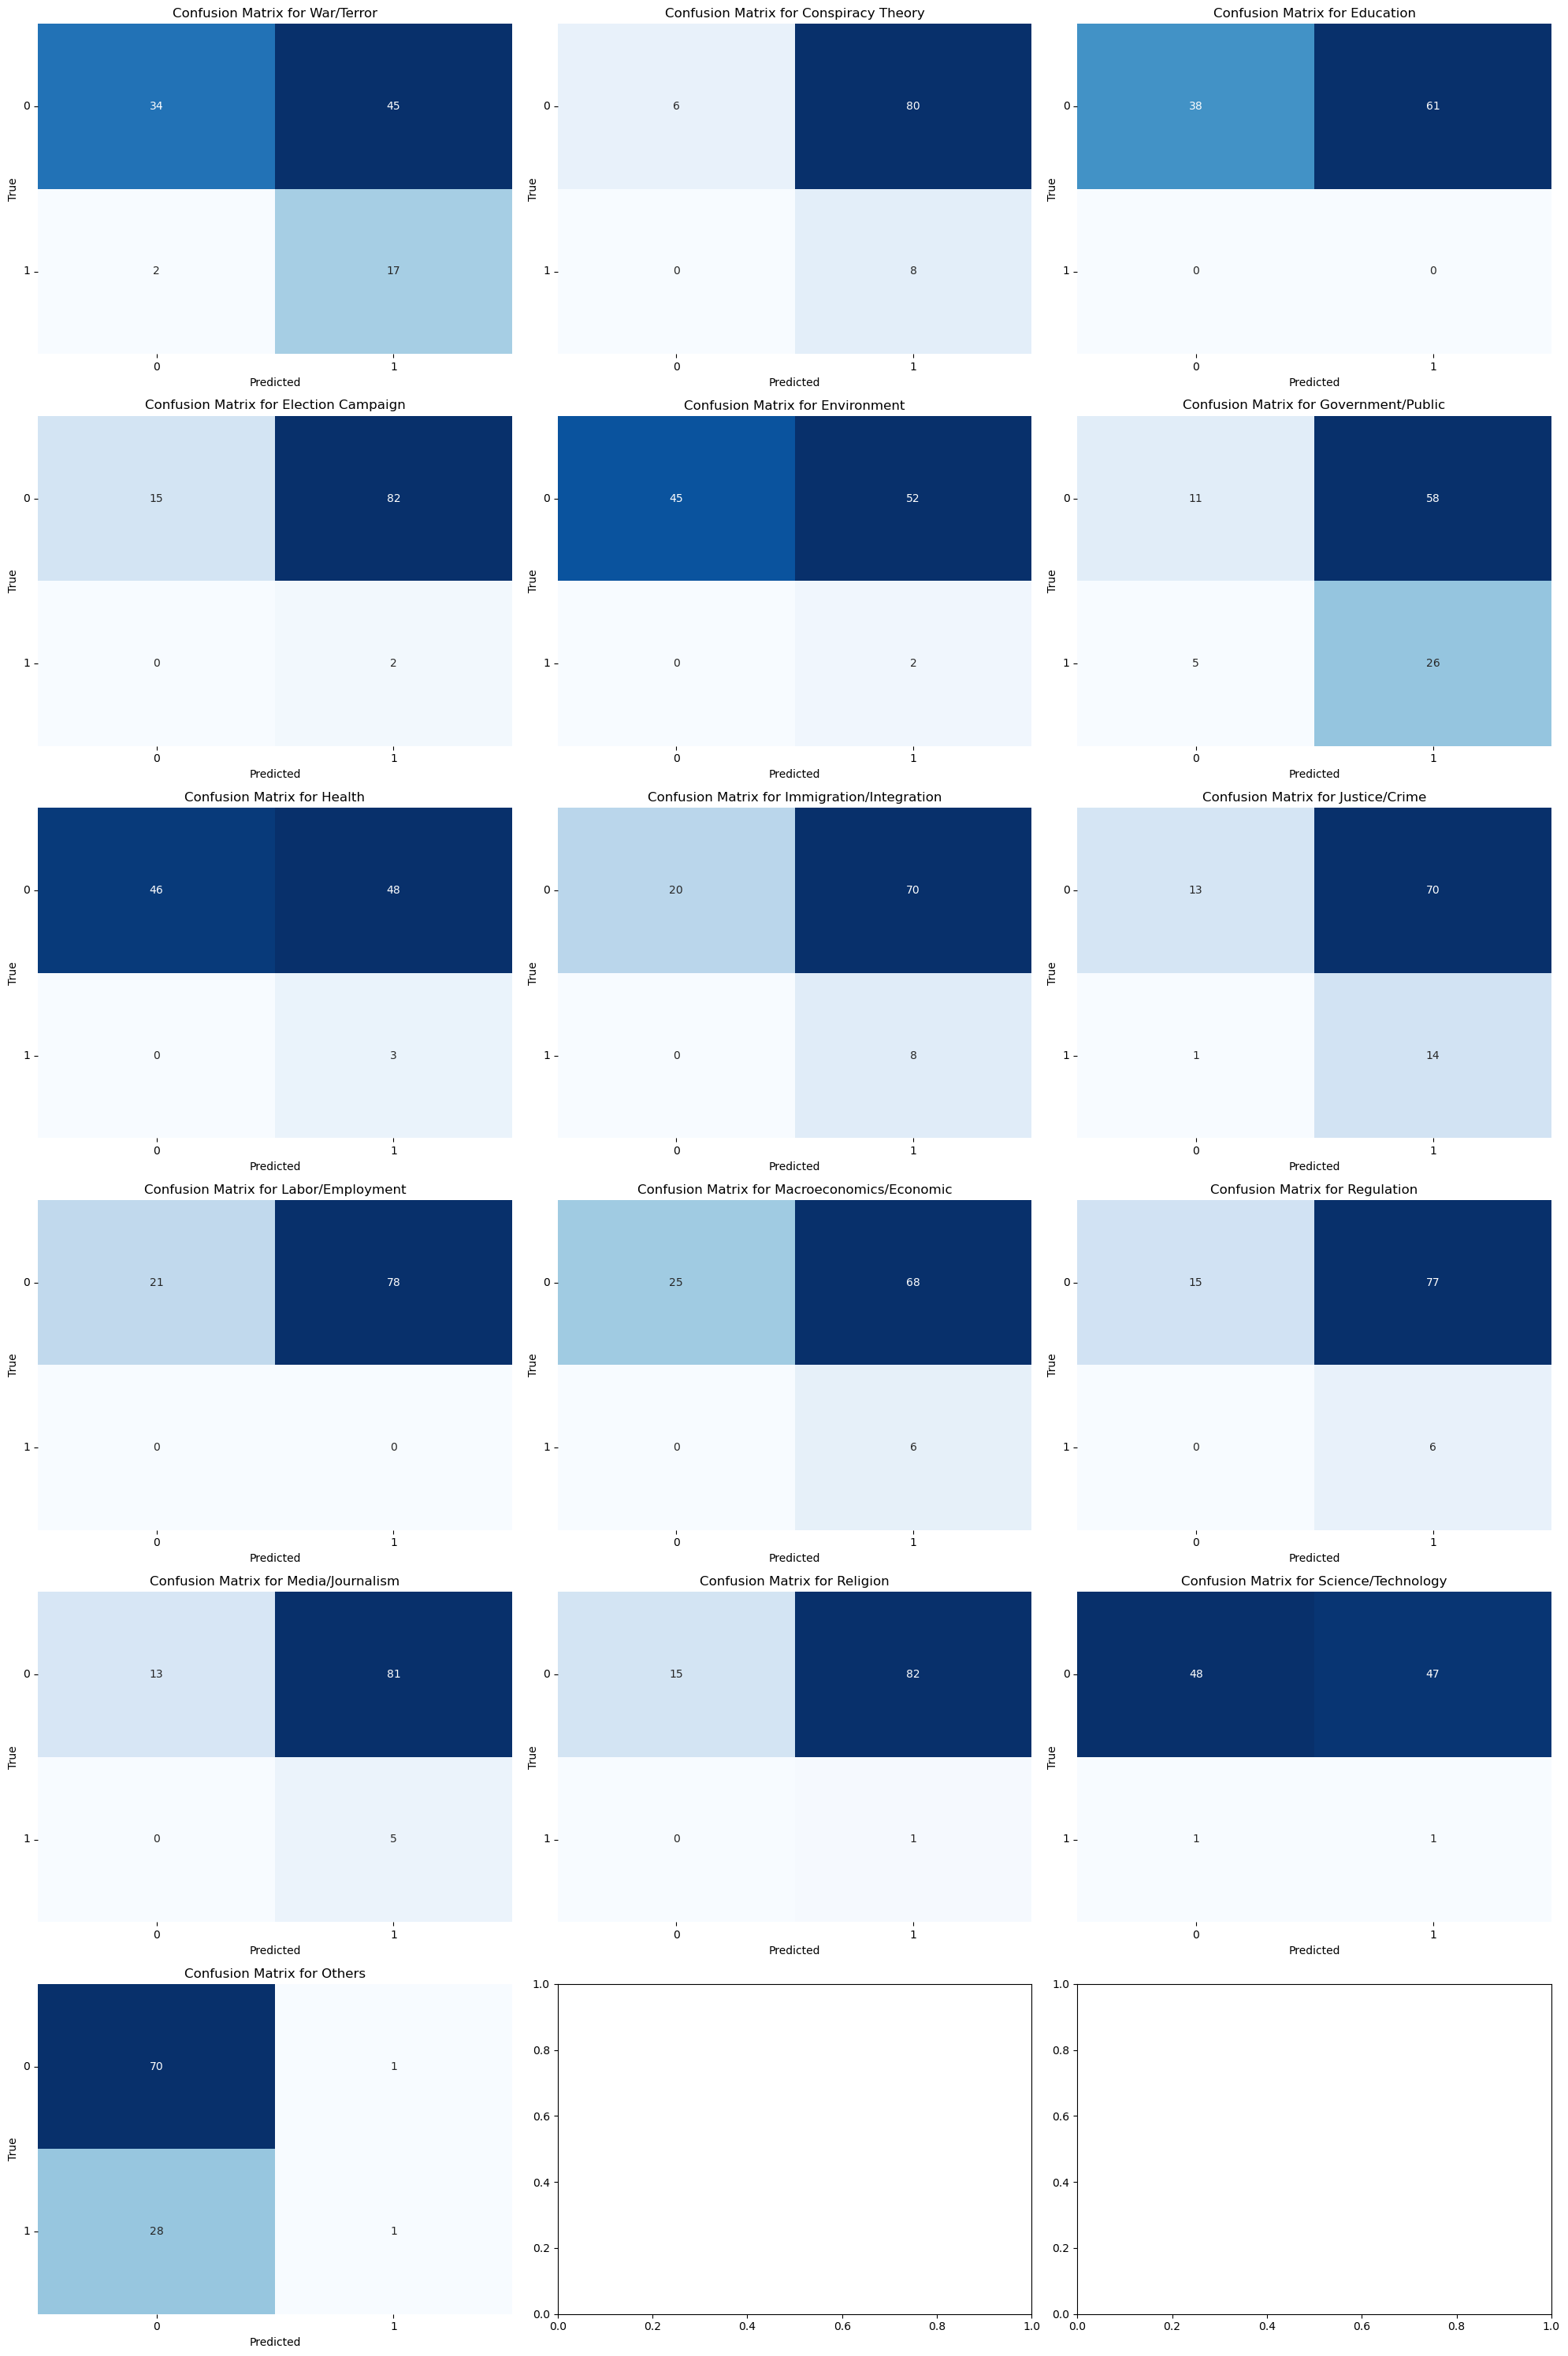

In [49]:
# Create a grid of subplots
fig, axes = plt.subplots(6, 3, figsize=(20, 30))
axes = axes.flatten()

# Visualize confusion matrices and print metrics table
for i, (label, cm) in enumerate(confusion_matrices.items()):
    ax = axes[i]
    
    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix for {label}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['0', '1'])
    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels(['0', '1'], rotation=0)

# Remove any unused subplots
for i in range(len(confusion_matrices), 15):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# List of unique class labels
class_labels = ['Class1', 'Class2', 'Class3']  # Replace with your actual class labels

# Function to convert 'Classification: [0 or 1]' string to int value
def extract_classification_value(classification_str):
    if pd.isna(classification_str):
        return None
    return int(classification_str.split(': ')[1])

# Iterate through class labels and extract binary predictions
for label in class_labels:
    pred_column_name = f"{label}_pred"
    test_df[pred_column_name] = test_df[pred_column_name].apply(extract_classification_value)

# Function to assign 'Others' label if none of the prediction columns have a 1
def assign_others(row):
    if not any(row[f"{label}_pred"] == 1 for label in class_labels):
        return ["Others"]
    return row['annotations']

test_df['annotations'] = test_df.apply(assign_others, axis=1)

# Calculate confusion matrices for each class
confusion_matrices = {}
for label in class_labels:
    pred_column_name = f"{label}_pred"
    
    # Ignore rows with NaN values
    valid_rows = test_df[pred_column_name].notna()
    
    y_true = test_df.loc[valid_rows, 'annotations'].apply(lambda x: int(label in x))
    y_pred = test_df.loc[valid_rows, pred_column_name].astype(int)

    cm = confusion_matrix(y_true, y_pred)
    confusion_matrices[label] = cm

# Print confusion matrices
for label, cm in confusion_matrices.items():
    print(f"Confusion matrix for {label}:")
    print(cm)
    print()

In [105]:
def is_war_terror(annotations):
    return int('War/Terror' in annotations)

# Extract the binary classification from the "api_results" column
test_df['api_results_binary'] = test_df['api_results'].str.extract('Classification: (\d)')[0].replace(np.nan, -1).astype(int)

# Convert the multilabel "annotations" column to binary based on the appearance of "War/Terror"
test_df['annotations_binary'] = test_df['annotations'].apply(is_war_terror)

# Filter out the rows with NaN values (now represented as -1)
valid_rows = test_df['api_results_binary'] != -1

# Calculate the accuracy using only valid rows
accuracy = (test_df.loc[valid_rows, 'api_results_binary'] == test_df.loc[valid_rows, 'annotations_binary']).mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.55


In [106]:
# Identify the correct and incorrect classifications
test_df['correct_classification'] = test_df['api_results_binary'] == test_df['annotations_binary']

# Get samples of correct and incorrect classifications
correct_sample = test_df[test_df['correct_classification']].sample(5)
incorrect_sample = test_df[~test_df['correct_classification']].sample(5)

print("Correctly classified rows:")
print(correct_sample[['text', 'annotations', 'api_results_binary']])

Correctly classified rows:
                                                   text  \
1662  RT @tfAcj0F9IYtVsSq: Representatives of The #R...   
1242  RT @KampalaPost: 2018 Commonwealth Games: Ugan...   
962   Or the government should lead the effort to en...   
410   Democratic Republic of Congo President Felix T...   
3128  The new culture war: how​ ​Hollywood took on​ ...   

                                            annotations  api_results_binary  
1662          ['Immigration/Integration', 'War/Terror']                   1  
1242                                         ['Others']                   0  
962   ['Government/Public', 'Macroeconomics/Economic...                   0  
410                               ['Government/Public']                   0  
3128                              ['Government/Public']                   0  


In [107]:
print("\nIncorrectly classified rows:")
print(incorrect_sample[['text', 'annotations', 'api_results_binary']])


Incorrectly classified rows:
                                                   text  \
2210  RT DanaLovinLife1: #boycottSpecialists https:/...   
680   RT @fcn_84: 176 Venezuelan public entities hav...   
944   Scott Baio PHYSICALLY ATTACKED by the Wife of ...   
192   This Friday, September 25, the project " Volun...   
867   RT @uganda_front: A dedicated Uganda Police Fo...   

                                            annotations  api_results_binary  
2210                                         ['Others']                   1  
680   ['Government/Public', 'Macroeconomics/Economic...                   1  
944              ['Government/Public', 'Justice/Crime']                   1  
192                               ['Government/Public']                   1  
867              ['Government/Public', 'Justice/Crime']                   1  
